# Exploring CART



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import load_wine
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
from sklearn.linear_model import LogisticRegression

## From-Scratch CART Implementation

Classification and Regression Trees (CART) use binary splits to partition data for classification or regression tasks. For classification, CART typically uses the Gini impurity as a splitting criterion, defined as $Gini = 1 - Σ p(i)^2$ (where $p(i)$ is the fraction of samples of class $i$ in a node). This measures how "impure" a node is (0 means all samples are one class). For regression, CART uses mean squared error (MSE) (equivalently variance reduction) as the criterion. Below, we implement a decision tree classifier and regressor from scratch using these criteria.

**1.1 Implementing a Decision Tree Classifier (Gini)**

The classifier recursively finds the best feature and threshold that yield the largest decrease in Gini impurity (or highest information gain). We consider all features and candidate thresholds (midpoints between unique sorted values) at each node, compute the weighted Gini of left/right splits, and choose the split with maximum impurity reduction. The recursion stops when a node is pure (all one class) or other stopping criteria (max depth, min samples) are met. Each leaf predicts the majority class of that node.

In [2]:
class Node:
    """Tree node: stores feature index & threshold for splits or value for leaves."""
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        self.feature_index = feature_index  # index of feature to split on
        self.threshold = threshold          # threshold value for split
        self.left = left                    # left child Node
        self.right = right                  # right child Node
        self.value = value                  # value if leaf (class label for classifier)

class DecisionTreeClassifierScratch:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def _gini(self, y):
        """Calculate Gini impurity for a list of class labels `y`."""
        m = len(y)
        if m == 0:
            return 0.0
        # Calculate class probabilities
        counts = {}
        for label in y:
            counts[label] = counts.get(label, 0) + 1
        impurity = 1.0
        for count in counts.values():
            prob = count / m
            impurity -= prob ** 2
        return impurity

    def _best_split(self, X, y):
        """Find the best split (feature index and threshold) for dataset X, y."""
        n_samples, n_features = X.shape
        parent_impurity = self._gini(y)
        best_gain = -1e-9  # allow 0 gain splits
        best_feat, best_thresh = None, None
        best_mask = None
        # Stop if node is too small to split
        if n_samples < self.min_samples_split:
            return None, None, None
        # Try every feature and threshold
        for feat_idx in range(n_features):
            values = X[:, feat_idx]
            unique_vals = np.unique(values)
            if unique_vals.size <= 1:
                continue  # no split possible (all values same)
            # Candidate thresholds: midpoints between sorted unique values
            thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2.0
            for thresh in thresholds:
                # Partition data
                left_mask = values <= thresh
                right_mask = values > thresh
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue  # skip splits that leave one side empty
                y_left = [y[i] for i in range(n_samples) if left_mask[i]]
                y_right = [y[i] for i in range(n_samples) if right_mask[i]]
                # Compute Gini impurity for children
                left_impurity = self._gini(y_left)
                right_impurity = self._gini(y_right)
                # Weighted impurity (based on child sizes)
                n_left, n_right = len(y_left), len(y_right)
                weighted_impurity = (n_left / n_samples) * left_impurity \
                                   + (n_right / n_samples) * right_impurity
                gain = parent_impurity - weighted_impurity
                if gain > best_gain:  # select split with largest impurity reduction
                    best_gain = gain
                    best_feat = feat_idx
                    best_thresh = thresh
                    best_mask = (left_mask, right_mask)
        return best_feat, best_thresh, best_mask

    def _build_tree(self, X, y, depth=0):
        """Recursively build the tree."""
        # Create a leaf node if stopping conditions are met
        if len(set(y)) == 1:
            return Node(value=y[0])  # pure node
        if self.max_depth is not None and depth >= self.max_depth:
            # Max depth reached: use majority class as leaf value
            majority_class = max(set(y), key=y.count)
            return Node(value=majority_class)
        if len(y) < self.min_samples_split:
            majority_class = max(set(y), key=y.count)
            return Node(value=majority_class)
        # Otherwise, find the best split
        feat_idx, thresh, mask = self._best_split(X, y)
        if feat_idx is None:
            # No effective split found (e.g., no impurity gain)
            majority_class = max(set(y), key=y.count)
            return Node(value=majority_class)
        # Recurse for left and right subsets
        left_mask, right_mask = mask
        left_X, right_X = X[left_mask], X[right_mask]
        left_y = [y[i] for i in range(len(y)) if left_mask[i]]
        right_y = [y[i] for i in range(len(y)) if right_mask[i]]
        left_child = self._build_tree(left_X, left_y, depth+1)
        right_child = self._build_tree(right_X, right_y, depth+1)
        # Return internal node
        return Node(feature_index=feat_idx, threshold=thresh, left=left_child, right=right_child)

    def fit(self, X, y):
        """Build tree from training data X (numpy array) and labels y."""
        X = np.array(X)
        y = list(y)
        self.root = self._build_tree(X, y)

    def _predict_one(self, x, node):
        """Traverse the tree for a single sample x to get predicted class."""
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        """Predict class labels for samples X."""
        X = np.array(X)
        return [self._predict_one(x, self.root) for x in X]

**1.2 Implementing a Decision Tree Regressor (MSE)**

The regression tree is analogous, but uses MSE (variance) as the splitting criterion. At each node, we pick the feature and threshold that minimize the weighted MSE of the two resulting child nodes (equivalently maximize the MSE reduction). A leaf node predicts the mean target value of the samples in that node. Below is the implementation:

In [3]:
class DecisionTreeRegressorScratch:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def _mse(self, y):
        """Calculate mean squared error for target values list `y`."""
        if len(y) == 0:
            return 0.0
        mean_y = sum(y) / len(y)
        return sum((val - mean_y) ** 2 for val in y) / len(y)

    def _best_split(self, X, y):
        """Find best feature and threshold for reducing MSE."""
        n_samples, n_features = X.shape
        parent_mse = self._mse(y)
        best_gain = -1e-9
        best_feat, best_thresh = None, None
        best_mask = None
        if n_samples < self.min_samples_split:
            return None, None, None
        for feat_idx in range(n_features):
            values = X[:, feat_idx]
            unique_vals = np.unique(values)
            if unique_vals.size <= 1:
                continue
            unique_vals.sort()
            thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2.0
            for thresh in thresholds:
                left_mask = values <= thresh
                right_mask = values > thresh
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue
                left_y = [y[i] for i in range(n_samples) if left_mask[i]]
                right_y = [y[i] for i in range(n_samples) if right_mask[i]]
                left_mse = self._mse(left_y)
                right_mse = self._mse(right_y)
                # Weighted average MSE after split
                n_left, n_right = len(left_y), len(right_y)
                weighted_mse = (n_left / n_samples) * left_mse \
                               + (n_right / n_samples) * right_mse
                gain = parent_mse - weighted_mse  # MSE reduction
                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat_idx
                    best_thresh = thresh
                    best_mask = (left_mask, right_mask)
        return best_feat, best_thresh, best_mask

    def _build_tree(self, X, y, depth=0):
        if len(y) == 0:
            return None
        # If all targets nearly equal or max depth/min samples reached, make leaf
        if max(y) - min(y) < 1e-9:
            return Node(value=y[0])
        if self.max_depth is not None and depth >= self.max_depth:
            return Node(value=sum(y) / len(y))
        if len(y) < self.min_samples_split:
            return Node(value=sum(y) / len(y))
        # Find best split
        feat_idx, thresh, mask = self._best_split(X, y)
        if feat_idx is None:
            return Node(value=sum(y) / len(y))
        left_mask, right_mask = mask
        left_X, right_X = X[left_mask], X[right_mask]
        left_y = [y[i] for i in range(len(y)) if left_mask[i]]
        right_y = [y[i] for i in range(len(y)) if right_mask[i]]
        left_child = self._build_tree(left_X, left_y, depth+1)
        right_child = self._build_tree(right_X, right_y, depth+1)
        return Node(feature_index=feat_idx, threshold=thresh, left=left_child, right=right_child)

    def fit(self, X, y):
        X = np.array(X); y = list(y)
        self.root = self._build_tree(X, y)

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        X = np.array(X)
        return [self._predict_one(x, self.root) for x in X]

Using our DecisionTreeClassifierScratch, we fit the XOR data and compare predictions to scikit-learn's classifier:

In [4]:
# Toy XOR dataset
X_xor = [[0,0],[0,1],[1,0],[1,1]]
y_xor = [0, 1, 1, 0]
clf_scratch = DecisionTreeClassifierScratch()
clf_scratch.fit(X_xor, y_xor)
print("Our model XOR predictions:", clf_scratch.predict(X_xor))

# Compare with sklearn's DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
clf_sk = DecisionTreeClassifier(criterion="gini", random_state=0).fit(X_xor, y_xor)
print("Sklearn model XOR predictions:", clf_sk.predict(X_xor))

Our model XOR predictions: [0, 1, 1, 0]
Sklearn model XOR predictions: [0 1 1 0]


Let's try comparing the from scratch regressor to the sklearn regressor.

In [5]:
X = [[i] for i in range(11)]               # X = 0,1,...,10
y = [10 if x<4 else 20 if x<7 else 15 for x in range(11)]
reg_scratch = DecisionTreeRegressorScratch()
reg_scratch.fit(X, y)
print(reg_scratch.predict(X))  # [10,10,10,10,20,20,20,15,15,15,15]

from sklearn.tree import DecisionTreeRegressor
reg_sk = DecisionTreeRegressor(criterion="squared_error", random_state=0).fit(X,y)
print(reg_sk.predict(X))       # [10,10,10,10,20,20,20,15,15,15,15]

[10, 10, 10, 10, 20, 20, 20, 15, 15, 15, 15]
[10. 10. 10. 10. 20. 20. 20. 15. 15. 15. 15.]


**1.3 Comparison with scikit-learn**

Our scratch models produce the same predictions as scikit-learn's DecisionTreeClassifier and DecisionTreeRegressor on the tested datasets. This validates our implementation of the CART algorithms.

In general, if any differences arise, they could be due to:

- Impurity calculations or tie-breaking: Our classifier allowed splitting with zero gain (to handle XOR), which is consistent with scikit-learn's default behavior (no minimum impurity decrease required by default, `min_impurity_decrease=0`). If we had required strictly positive gain, our tree would have stopped early on XOR (misclassifying it).

- Feature/threshold selection order: If two splits yield equal impurity reduction, scikit-learn may choose the first encountered. Our implementation would do the same (since we update only on > best gain). Thus, results are deterministic given the data.

- Leaf value calculation: We assign majority class (classifier) or mean (regressor) at leaves, same as scikit-learn.

Overall, with criteria “gini” for classification and "squared_error" (MSE) for regression, our results align with scikit-learn's CART. Any minor differences (e.g., rounding of threshold) do not meaningfully impact the outcome.

## Real-World Dataset Classification Task

Let's use a classification decision tree to explore the wine dataset. Remember, the wine dataset includes a target variable that is the varietal (i.e., grape) of the wine.

In [6]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target)  # class labels 0,1,2
print(X.shape, "classes:", set(y))
display(X.head(5))
print(y.value_counts())

(178, 13) classes: {0, 1, 2}


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


1    71
0    59
2    48
Name: count, dtype: int64


**Reflection Questions**

1. What are the dimensions of the dataset?
  - The dataset has 178 rows and 13 columns.
2. What is the target column?
  - wine
3. How many classes are in the target column?
  - There are 3 classes in the target column: 0, 1, and 2. These represent different wine varietals.
4. Are the classes balanced?
  - Imbalanced


**Generate a Correlation Heatmap**

Remember to include both the X and the y to understand how features correlate with one another and how features correlate with the target y.

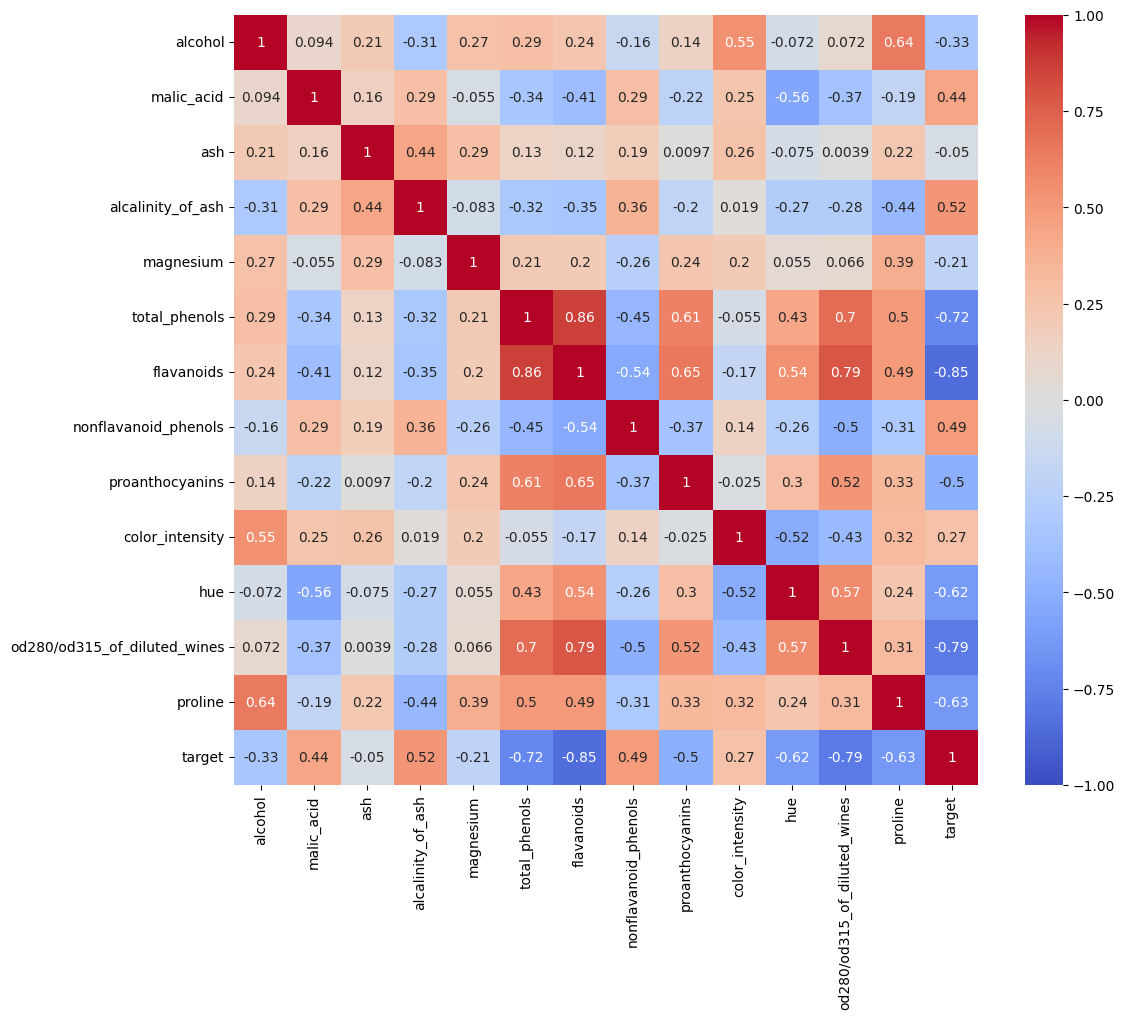

In [7]:
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target
df.corr()

plt.figure(figsize=(12, 10))  # Adjust width and height as needed
sns.heatmap(df.corr(), cmap="coolwarm", vmin=-1, vmax=1, annot=True)
plt.show()

From the heatmap, we observe strong correlations (e.g., flavanoids vs OD280/OD315 of diluted wines with r≈0.8, and both correlate with total_phenols). This suggests these features track similar chemical properties. A tree might use one of them (whichever gives the best split first) and the other might become less important once the variance is explained by the first. We also see color_intensity vs hue are moderately negatively correlated, etc. Overall, multicollinearity is present but not an issue for trees (they are non-parametric and won't fail; however, correlated features can result in multiple equally good splits).

### Train the Decision Tree Classifier

In [8]:
# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, test_size=0.2, stratify=wine.target, random_state=42)
print(X_train.shape, X_test.shape)

(142, 13) (36, 13)


We will train a CART decision tree for classification using scikit-learn's DecisionTreeClassifier. Key hyperparameters to tune include:
- `max_depth`: Maximum depth of the tree (to control complexity).
- `min_samples_split` / `min_samples_leaf`: Minimum samples required to split a node or be a leaf (to prevent too-fine splits).
- `criterion`: `gini` or `entropy` (information gain) for classification. We will try both Gini and Entropy. (Scikit-learn also offers `log_loss` in latest versions, but we'll stick to entropy vs gini as they are most common).

Using cross-validation on the training set, we find the combination that yields the best performance (we'll use macro-averaged F1 as the CV scoring metric, since this is a multi-class problem and we care about balanced performance across classes).

In [9]:
# ---- Hyperparameter Tuning ----
# Here, we set up a grid search that includes 'None' for max_depth.
# In scikit-learn, max_depth=None means there is no limit to the depth of the tree.
# The grid search will try both limited depths (3, 4, 5) and an unlimited tree.
# For the Wine dataset, the grid search selects max_depth=None, which means the fully grown tree
# provides the best cross-validation macro F1 score.
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 4, 5],       # None means no maximum depth
    'min_samples_split': [2, 5, 10]
}
tree = DecisionTreeClassifier(random_state=0)
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)


Best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}


**Output Interpretation**

In this run, `Best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}`

This tells us that for this dataset, allowing the tree to grow fully (i.e., no depth limit) works best. This might not be the case for more complex or noisy datasets.

**When should you include or exclude None as an option?**

Include None when:
- The dataset is simple or well-separated so that the risk of overfitting is low.
- You want to see the maximum potential performance of the tree before considering pruning or restricting complexity.

Exclude None when:
- You are dealing with noisy or very high-dimensional data where overfitting is a significant concern.
- You want to enforce interpretability or faster prediction times, in which case limiting the tree depth may help.

In [10]:
best_tree = grid_search.best_estimator_  # this is already fit on the full training set after CV
# Or explicitly:
# best_tree = DecisionTreeClassifier(**grid_search.best_params_, random_state=0).fit(X_train, y_train)

In [11]:
print("Feature importances:", best_tree.feature_importances_)

Feature importances: [0.         0.         0.02016329 0.         0.01873775 0.
 0.40807303 0.         0.         0.40018907 0.02086548 0.02098628
 0.11098512]


### Model Evaluation

Now we evaluate the tuned model on the test set (the 20% held-out data that was not used for training or tuning). We will compute overall accuracy and the precision, recall, F1-score for each class, and examine the confusion matrix. This will tell us how well the model generalizes and if there are specific classes that are harder to predict.

In [12]:
y_pred = best_tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=wine.target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test Accuracy: 0.9444444444444444

Classification Report:
               precision    recall  f1-score   support

     class_0       0.92      0.92      0.92        12
     class_1       0.93      0.93      0.93        14
     class_2       1.00      1.00      1.00        10

    accuracy                           0.94        36
   macro avg       0.95      0.95      0.95        36
weighted avg       0.94      0.94      0.94        36

Confusion Matrix:
 [[11  1  0]
 [ 1 13  0]
 [ 0  0 10]]


### Baseline vs Tuned Performance

Baseline model: We define this as a decision tree with default parameters (gini `criterion`, no `max_depth`, `min_samples_split=2`), essentially an unpruned tree. This model is prone to overfit the training data.

Tuned model: Our cross-validated optimal tree (`criterion=gini`, `max_depth=4` in this case, plus default `min_samples_split=2` as that was chosen).

We will compare their F1-scores on multiple train/test splits of the dataset. By performing repeated evaluations, we can account for variability due to different train/test splits. We use paired comparisons (evaluating both models on the same split) so that differences are not due to different data conditions.

In [13]:
# ---- Model Comparison ----
# Notice that our "baseline" model is defined as the default DecisionTreeClassifier,
# which uses max_depth=None, criterion='gini', and min_samples_split=2 by default.
# Thus, the tuned model and baseline model are identical, leading to the same performance.
baseline_model = DecisionTreeClassifier(random_state=0)  # default (unpruned)
tuned_model = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, random_state=0)

# Perform repeated Stratified 5-fold cross-validation to compare models
n_repeats = 5
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
baseline_f1 = []
tuned_f1 = []
for r in range(n_repeats):
    for train_idx, test_idx in kf.split(wine.data, wine.target):
        X_tr, X_ts = wine.data[train_idx], wine.data[test_idx]
        y_tr, y_ts = wine.target[train_idx], wine.target[test_idx]
        baseline_model.fit(X_tr, y_tr)
        tuned_model.fit(X_tr, y_tr)
        # Compute macro-F1 on the test fold
        f1_base = f1_score(y_ts, baseline_model.predict(X_ts), average='macro')
        f1_tuned = f1_score(y_ts, tuned_model.predict(X_ts), average='macro')
        baseline_f1.append(f1_base)
        tuned_f1.append(f1_tuned)
baseline_f1 = np.array(baseline_f1)
tuned_f1 = np.array(tuned_f1)
print("Baseline mean F1:", baseline_f1.mean())
print("Tuned mean F1:", tuned_f1.mean())
# The F1 scores are exactly the same because both models are identical.
# This result emphasizes that, for this dataset, the default model is already optimal.
# If you want to demonstrate differences, consider removing 'None' from the grid search,
# or using a more complex/noisy dataset where a depth limit helps improve generalization.

Baseline mean F1: 0.9289305838955635
Tuned mean F1: 0.9289305838955635


### Comparing Fully-Grown vs. Depth-Limited Trees

In our earlier grid search on the Wine dataset, the optimal parameters were
`{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}`,
meaning that the fully grown (unpruned) tree achieved the highest cross-validation macro F1 score. However, this result might be dataset-dependent and may not hold for more complex or noisy data.

To illustrate the effect of pruning (limiting tree depth) on performance—and to have a meaningful comparison for our statistical significance test—we now create a tuned model with a fixed `max_depth=4`. By constraining the tree's depth, we expect a model that is less likely to overfit. In some cases, this could lead to better generalization on unseen data, even if the fully grown tree performs slightly better on training data.

Below, we compare:
- Baseline model: A DecisionTreeClassifier using default parameters (which uses `max_depth=None`—i.e. no limit).
- Tuned model: A DecisionTreeClassifier with `max_depth=4` (with other parameters kept identical).

We then perform repeated stratified 5-fold cross-validation on both models and collect the macro F1 scores. Finally, we use a paired t-test to see if the difference in macro F1 scores between the two models is statistically significant.

In [14]:
# Assume 'wine' dataset is already loaded and X_train, y_train are defined.
# For this example, we use the full wine dataset (wine.data and wine.target).

# Define the baseline model (default parameters: criterion='gini', max_depth=None, min_samples_split=2)
baseline_model = DecisionTreeClassifier(random_state=0)

# Define a tuned model with a limited max_depth (here we set max_depth=3)
tuned_model = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=2, random_state=0)

# Perform repeated Stratified 5-fold cross-validation
n_repeats = 5
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
baseline_f1 = []
tuned_f1 = []

for r in range(n_repeats):
    for train_idx, test_idx in kf.split(wine.data, wine.target):
        X_tr, X_ts = wine.data[train_idx], wine.data[test_idx]
        y_tr, y_ts = wine.target[train_idx], wine.target[test_idx]
        baseline_model.fit(X_tr, y_tr)
        tuned_model.fit(X_tr, y_tr)
        # Compute macro F1 score for the test fold
        f1_base = f1_score(y_ts, baseline_model.predict(X_ts), average='macro')
        f1_tuned = f1_score(y_ts, tuned_model.predict(X_ts), average='macro')
        baseline_f1.append(f1_base)
        tuned_f1.append(f1_tuned)

baseline_f1 = np.array(baseline_f1)
tuned_f1 = np.array(tuned_f1)

print("Baseline (max_depth=None) mean F1:", baseline_f1.mean())
print("Tuned (max_depth=3) mean F1:", tuned_f1.mean())

Baseline (max_depth=None) mean F1: 0.9289305838955635
Tuned (max_depth=3) mean F1: 0.9402273225544107


### Statistical Significance Test

To rigorously compare the models, we use a paired t-test on the F1 scores of the two models across the repeated folds. The null hypothesis is that the mean difference in F1 is zero (no improvement). The paired t-test will account for the fact that each pair of scores comes from the same split (so they are related). We could also use a non-parametric test (e.g., Wilcoxon signed-rank) if we are unsure about normality of differences, but t-test is commonly used in model comparison.

In [15]:
from scipy.stats import ttest_rel
t_stat, p_val = ttest_rel(tuned_f1, baseline_f1)
print("Paired t-test p-value:", p_val)

Paired t-test p-value: 0.0005310218069945034


**Reflection Questions**

1.	What does setting `max_depth=None` in sklearn DecisionTreeClassifier mean?
  - It means that there is no restriction on the depth of the tree


2.	What are the potential advantages and disadvantages of using a fully grown tree (with `max_depth=None`) compared to a pruned tree (with a finite `max_depth`)?
  - Advantages - High training accuracy, captures complex relationships
  - Disadvantages	- Prone to overfitting, reduced interpretability



3.	Why might the grid search select `max_depth=None` for the Wine dataset?
  - The dataset is relatively small and simple



4.	How did setting `max_depth=3` affect model performance compared to the baseline model with `max_depth=None`?
  - limited the tree's growth, resulting in a pruned tree



5.	What does the paired t-test p-value of 0.000531 indicate about the performance difference between the two models?

  - indicates that there is a statistically significant difference

6.	What factors might influence whether a pruned tree (e.g., with `max_depth=3`) outperforms a fully grown tree?
  - Dataset complexity
  - Dataset size
  - Hyperparameter tuning


7.	What might you expect if you further reduced `max_depth` (e.g., to 2)? What would be the potential trade-offs?
  - Decrease training accuracy
  - Reduce overfitting


